In [110]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

# Posibles estrategias:
## Generales

### Problem transformation:
Transforma el problema para llevarlo a uno de multiclass
- **Binary Relevance**: Entrenar cada uno por separado. Puede haber fuerte correlación y este modelo no lo tiene en cuenta. Es decir, dada una clase, es muy poco probable que pertenezca a otra clase o viceverza
- **Classifier Chains**: Usar salida de las clases anteriores como entrada. Puede tener el problema que si predigo mal una clase, condiciono la predicción de la siguiente. Es un pipeline, uno informa el resultado al otro pero no viceverza
- **Label Powerset**: Generar tantas clases como combinaciones de posibles salidas haya en el dataset. A medida que el dataset crece podrían aparecer todas las combinaciones de clases.

### Adaptacion de Algoritmo: 
Adaptar alguno de las tecnicas ya utilizadas como MLP para realizar multilabel

## Redes neuronales:
- Binary relevance neural network (BRNN)
- Threshold dependent neural network (TDNN): Softmax
- Joint binary neural network (JBNN), https://arxiv.org/pdf/1802.00891.pdf

In [2]:
N = 200
X1 = np.random.uniform(-1,1, N)
X2 = np.random.uniform(-1,1, N)
X = np.vstack([X1, X2]).T
X.shape

(200, 2)

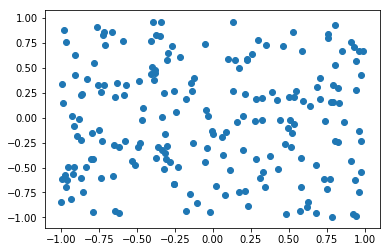

In [3]:
plt.scatter(X1, X2)
plt.show()

In [4]:
y = []
for x in X:
    yaux = np.array([0, 0, 0, 0])
    if x[0]**2+x[1]**2>0.5:
        yaux = yaux + np.array([1, 0, 0, 0])
    else:
        yaux = yaux + np.array([0, 1, 0, 0])
    if x[0]**2-x[1]**2>0:
        yaux = yaux + np.array([0, 0, 1, 0])
    else:
        yaux = yaux + np.array([0, 0, 0, 1])
    y.append(list(yaux))
y = np.array(y)

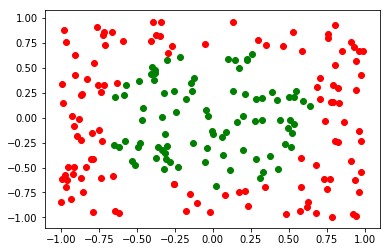

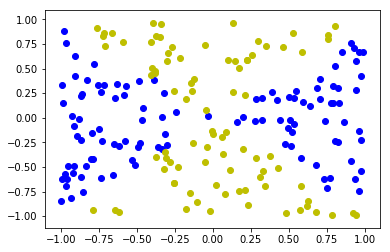

In [5]:
plt.scatter(X[y[:,0]==1, 0], X[y[:,0]==1, 1], c='r')
plt.scatter(X[y[:,1]==1, 0], X[y[:,1]==1, 1], c='g')
plt.show()
plt.scatter(X[y[:,2]==1, 0], X[y[:,2]==1, 1], c='b')
plt.scatter(X[y[:,3]==1, 0], X[y[:,3]==1, 1], c='y')
plt.show()

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [7]:
from keras.models import Sequential
from keras import optimizers
from keras.layers.core import Dense, Activation
from helper import PlotLosses
from keras.callbacks import ModelCheckpoint
from keras.initializers import RandomNormal
from keras import regularizers

Using TensorFlow backend.


# Red Neuronal Sigmoideas + binary_crossentropy

In [10]:
hidden_units = 20
input_features=2
output_size = y_train.shape[1]
lambd = 0 #0.001
model_sig_nn = Sequential()
model_sig_nn.add(Dense(hidden_units,input_dim=input_features, kernel_regularizer=regularizers.l2(lambd), name="Capa_Oculta"))
model_sig_nn.add(Activation('sigmoid', name="sigmoid"))
model_sig_nn.add(Dense(output_size, name="Salida"))
model_sig_nn.add(Activation('sigmoid', name="output")) 
model_sig_nn.summary()


lr = 0.05 
batch_size = 20
epochs = 1000

#selectedOptimizer = optimizers.SGD(lr=lr)
selectedOptimizer = optimizers.adam(lr=lr)

# Lo compilo, notar que en vez de binary_crossentropy va categorical_crossentropy
model_sig_nn.compile(loss = 'binary_crossentropy', optimizer=selectedOptimizer, metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Capa_Oculta (Dense)          (None, 20)                60        
_________________________________________________________________
sigmoid (Activation)         (None, 20)                0         
_________________________________________________________________
Salida (Dense)               (None, 4)                 84        
_________________________________________________________________
output (Activation)          (None, 4)                 0         
Total params: 144
Trainable params: 144
Non-trainable params: 0
_________________________________________________________________


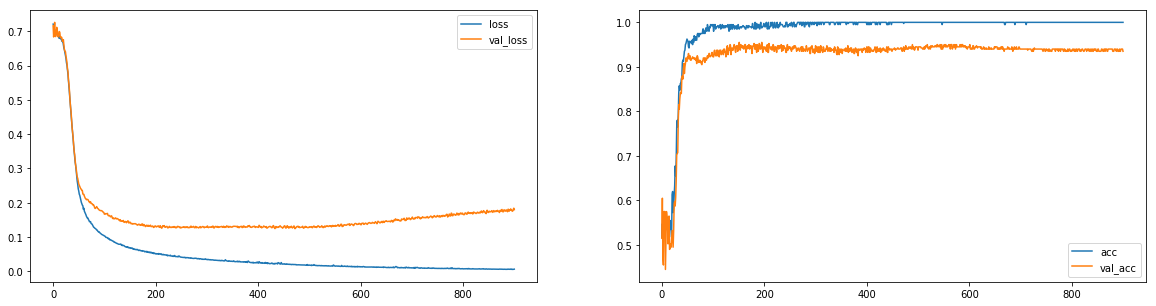

In [11]:
plot_losses = PlotLosses(plot_interval=100, 
                         evaluate_interval=None, 
                         x_val=X_test, 
                         y_val_categorical=y_test)
model_sig_nn.fit(X_train, 
          y_train, 
          batch_size = batch_size,
          epochs=epochs, 
          verbose=0, 
          validation_data=(X_test, y_test), 
          callbacks=[plot_losses],
         )

In [12]:
print(np.round(model_sig_nn.predict_proba(X_train[:3])*100))
print(y_train[:3])

3/3 [==============================] - 0s
[[   0.  100.    0.  100.]
 [   0.  100.  100.    0.]
 [ 100.    0.    0.  100.]]
[[0 1 0 1]
 [0 1 1 0]
 [1 0 0 1]]


In [17]:
print("Acc, loss en train:",model_sig_nn.evaluate(X_train, y_train, verbose=0))

Acc, loss en train: [0.0048168945475481452, 1.0]


In [18]:
print("Acc, loss en test:",model_sig_nn.evaluate(X_test, y_test, verbose=0))

Acc, loss en test: [0.19172183275222779, 0.9375]


# Red Neuronal Softmax + categorical_crossentropy

In [19]:
input_features = 2
hidden_units = 20
lambd = 0 #0.001
output_size = y_train.shape[1]
model_sm_nn = Sequential()
model_sm_nn.add(Dense(hidden_units,input_dim=input_features, kernel_regularizer=regularizers.l2(lambd), name="Capa_Oculta"))
model_sm_nn.add(Activation('sigmoid', name="sigmoid"))
model_sm_nn.add(Dense(output_size, name="Salida"))
model_sm_nn.add(Activation('softmax', name="softmax")) # Notar que en vez de sigmoidea es softmax
model_sm_nn.summary()


lr = 0.05 
batch_size = 20
epochs = 1000

#selectedOptimizer = optimizers.SGD(lr=lr)
selectedOptimizer = optimizers.adam(lr=lr)

# Lo compilo, notar que en vez de binary_crossentropy va categorical_crossentropy
model_sm_nn.compile(loss = 'categorical_crossentropy', optimizer=selectedOptimizer, metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Capa_Oculta (Dense)          (None, 20)                60        
_________________________________________________________________
sigmoid (Activation)         (None, 20)                0         
_________________________________________________________________
Salida (Dense)               (None, 4)                 84        
_________________________________________________________________
softmax (Activation)         (None, 4)                 0         
Total params: 144
Trainable params: 144
Non-trainable params: 0
_________________________________________________________________


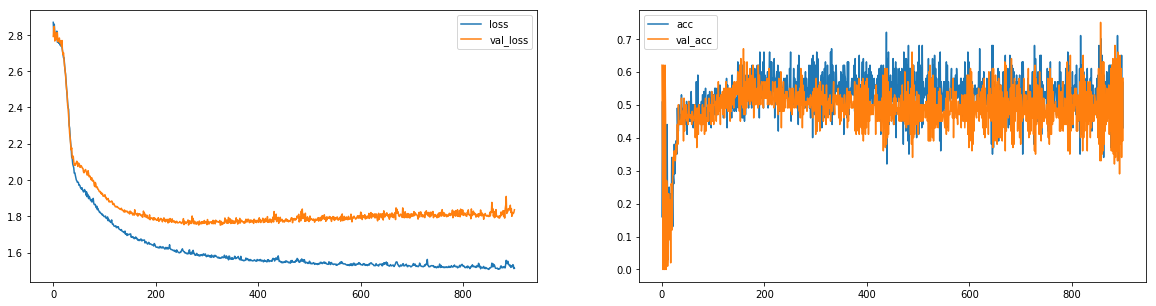

In [20]:
plot_losses = PlotLosses(plot_interval=100, 
                         evaluate_interval=None, 
                         x_val=X_test, 
                         y_val_categorical=y_test)
model_sm_nn.fit(X_train, 
          y_train, 
          batch_size = batch_size,
          epochs=epochs, 
          verbose=0, 
          validation_data=(X_test, y_test), 
          callbacks=[plot_losses],
         )

In [21]:
sample_predict = model_sm_nn.predict_proba(X_train[:3])
print(np.round(sample_predict*100))
print(y_train[:3])

3/3 [==============================] - 0s
[[  0.  51.   4.  45.]
 [  0.  51.  48.   0.]
 [ 59.   1.   0.  40.]]
[[0 1 0 1]
 [0 1 1 0]
 [1 0 0 1]]


In [122]:
def getAccuracy_0(model, X_train, y_train):
    # Sabiendo que son siempre 2, busco los dos máximos y los considero como los correctos
    sample_predict = model.predict_proba(X_train, verbose=0)
    # Divido por el segundo y me quedo con los que dan mayores a cero
    predicted_matrix = (sample_predict.T/np.sort(sample_predict)[:,-2]).T>=1
    # True positives
    TP = np.sum(predicted_matrix*y_train)
    # True negatives
    FP = np.sum(predicted_matrix*(1-y_train))
    # True negatives
    TN = np.sum((1-predicted_matrix)*(1-y_train))
    # False negatives
    FN = np.sum((1-predicted_matrix)*y_train)
    N = y_train.shape[0]*y_train.shape[1]
    print('True Positives:',TP)
    print('False Positives:',FP)
    print('True Negatives', TN)
    print('False Negatives', FN)
    return (TP+TN)/N

def getAccuracy_1(model, X_train, y_train, umbral = 0.5, roc = False):
    # En este caso estoy haciendo micro-average por que calculo el acc luego de sumar todo
    # Podría calcular el acc para cada clase y luego promediar -? macro average
    prediction = model.predict(X_train)
    predicted_matrix = (prediction.T/np.max(prediction, axis=1)).T > umbral
    # True positives
    TP = np.sum(predicted_matrix*y_train)
    # True negatives
    FP = np.sum(predicted_matrix*(1-y_train))
    # True negatives
    TN = np.sum((1-predicted_matrix)*(1-y_train))
    # False negatives
    FN = np.sum((1-predicted_matrix)*y_train)
    N = y_train.shape[0]*y_train.shape[1]
    
    Total_Pos = y_train.sum()
    Total_Neg = N - y_train.sum()
    
    if (roc):
        return FP/Total_Neg, TP/Total_Pos
    else:
        print('True Positives:',TP)
        print('False Positives:',FP)
        print('True Negatives', TN)
        print('False Negatives', FN)
    return (TP+TN)/N

In [123]:
print('Acc:', getAccuracy_0(model_sm_nn, X_train, y_train))
print('_____________________________')
print('Acc:', getAccuracy_1(model_sm_nn, X_train, y_train, umbral = 0.4))

True Positives: 200
False Positives: 0
True Negatives 200
False Negatives 0
Acc: 1.0
_____________________________
True Positives: 193
False Positives: 2
True Negatives 198
False Negatives 7
Acc: 0.9775


In [135]:
def get_ROC(model_sm_nn, X_train, y_train, N=500):
    umbral_arr = np.linspace(0,1, N)
    FP_arr_sm_nn = []
    TP_arr_sm_nn = []
    for thres in umbral_arr:
        FP, TP = getAccuracy_1(model_sm_nn, X_train, y_train, umbral = thres, roc = True)
        FP_arr_sm_nn.append(FP)
        TP_arr_sm_nn.append(TP)
    return FP_arr_sm_nn, TP_arr_sm_nn

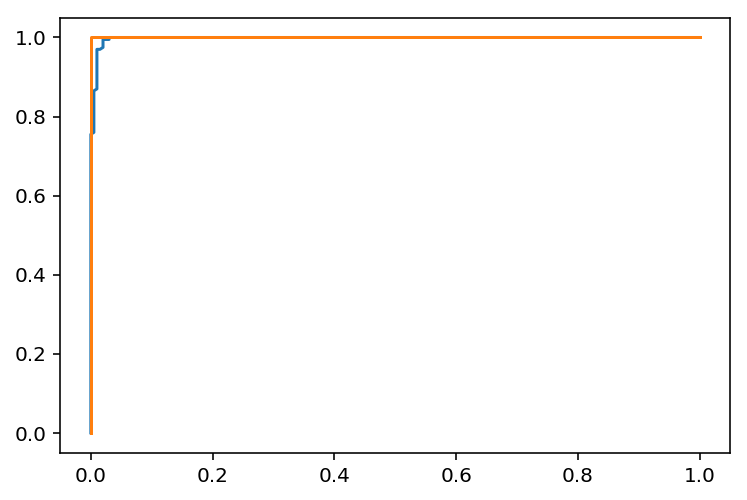

In [137]:
FP_arr_sm_nn, TP_arr_sm_nn = get_ROC(model_sm_nn, X_train, y_train)
FP_arr_sig_nn, TP_arr_sig_nn = get_ROC(model_sig_nn, X_train, y_train)
zoom = 500
plt.plot(FP_arr_sm_nn[:zoom], TP_arr_sm_nn[:zoom])
plt.plot(FP_arr_sig_nn[:zoom], TP_arr_sig_nn[:zoom])
plt.show()

# Red Neuronal Softmax Normalizada

In [440]:
input_features = 2
hidden_units = 20
lambd = 0 #0.001
output_size = y_train_norm.shape[1]
model_sm_nn_norm = Sequential()
model_sm_nn_norm.add(Dense(hidden_units,input_dim=input_features, kernel_regularizer=regularizers.l2(lambd), name="Capa_Oculta"))
model_sm_nn_norm.add(Activation('sigmoid', name="sigmoid"))
model_sm_nn_norm.add(Dense(output_size, name="Salida"))
model_sm_nn_norm.add(Activation('softmax', name="softmax")) # Notar que en vez de sigmoidea es softmax
model_sm_nn_norm.summary()


lr = 0.05 
batch_size = 20
epochs = 1000

#selectedOptimizer = optimizers.SGD(lr=lr)
selectedOptimizer = optimizers.adam(lr=lr)

# Lo compilo, notar que en vez de binary_crossentropy va categorical_crossentropy
model_sm_nn_norm.compile(loss = 'categorical_crossentropy', optimizer=selectedOptimizer, metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Capa_Oculta (Dense)          (None, 20)                60        
_________________________________________________________________
sigmoid (Activation)         (None, 20)                0         
_________________________________________________________________
Salida (Dense)               (None, 4)                 84        
_________________________________________________________________
softmax (Activation)         (None, 4)                 0         
Total params: 144
Trainable params: 144
Non-trainable params: 0
_________________________________________________________________


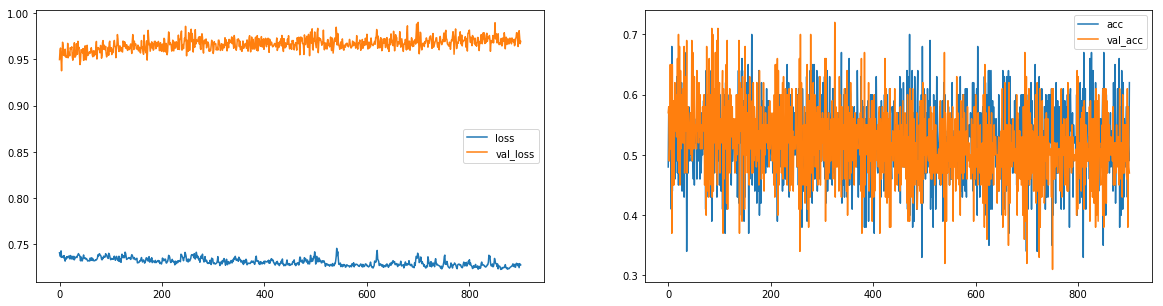

In [443]:
plot_losses = PlotLosses(plot_interval=100, 
                         evaluate_interval=None, 
                         x_val=X_test, 
                         y_val_categorical=y_test_norm)
model_sm_nn_norm.fit(X_train, 
          y_train_norm, 
          batch_size = batch_size,
          epochs=epochs, 
          verbose=0, 
          validation_data=(X_test, y_test_norm), 
          callbacks=[plot_losses],
         )

In [444]:
print(getAccuracy_softmax_0(model_sm_nn_norm, X_train, y_train))
getAccuracy_softmax(model_sm_nn_norm, X_train, y_train, umbral = 0.5)

0.995
195
0


0.98750000000000004

# kullback_leibler_divergence

Que pasa si ponemos sigmoideas aca?

In [423]:
input_features = 2
hidden_units = 20
lambd = 0 #0.001
output_size = y_train_norm.shape[1]
model_kl = Sequential()
model_kl.add(Dense(hidden_units,input_dim=input_features, kernel_regularizer=regularizers.l2(lambd), name="Capa_Oculta"))
model_kl.add(Activation('sigmoid', name="sigmoid"))
model_kl.add(Dense(output_size, name="Salida"))
model_kl.add(Activation('softmax', name="softmax")) # Notar que en vez de sigmoidea es softmax
model_kl.summary()


lr = 0.05 
batch_size = 20
epochs = 2000

#selectedOptimizer = optimizers.SGD(lr=lr)
selectedOptimizer = optimizers.adam(lr=lr)

# Lo compilo, notar que en vez de binary_crossentropy va categorical_crossentropy
model_kl.compile(loss = 'kullback_leibler_divergence', optimizer=selectedOptimizer, metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Capa_Oculta (Dense)          (None, 20)                60        
_________________________________________________________________
sigmoid (Activation)         (None, 20)                0         
_________________________________________________________________
Salida (Dense)               (None, 4)                 84        
_________________________________________________________________
softmax (Activation)         (None, 4)                 0         
Total params: 144
Trainable params: 144
Non-trainable params: 0
_________________________________________________________________


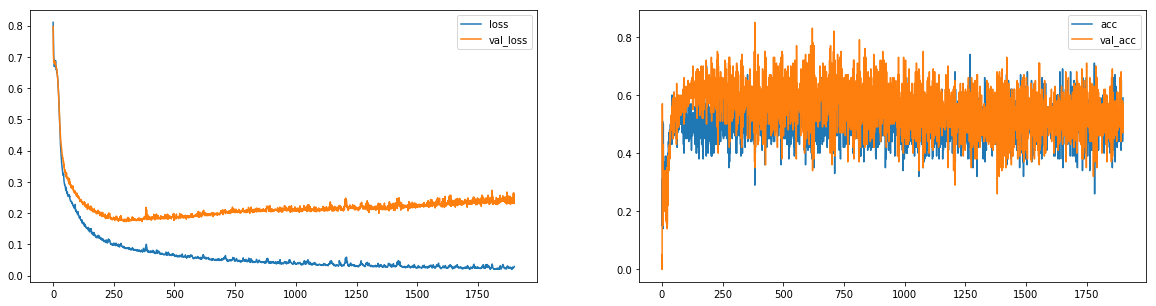

In [424]:
plot_losses = PlotLosses(plot_interval=100, 
                         evaluate_interval=None, 
                         x_val=X_test, 
                         y_val_categorical=y_test_norm)
model_kl.fit(X_train, 
          y_train_norm, 
          batch_size = batch_size,
          epochs=epochs, 
          verbose=0, 
          validation_data=(X_test, y_test_norm), 
          callbacks=[plot_losses],
         )

In [434]:
print(getAccuracy_softmax_0(model_kl, X_train, y_train))
getAccuracy_softmax(model_kl, X_train, y_train, umbral = 0.5)

0.995
200
0


1.0